# 1. Cotraining  Concept
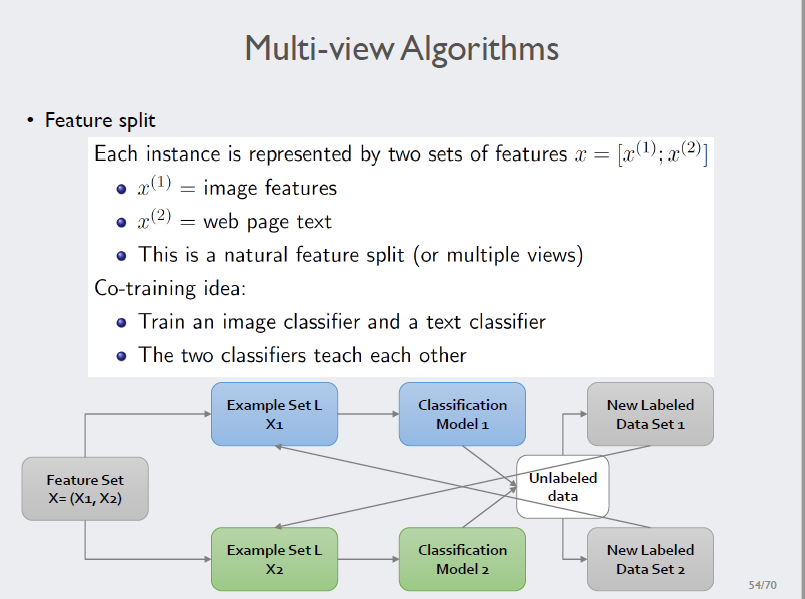

Step1) Feature set을 둘로 나누어 2개의 Classifier에 할당한다.

Step2) Labeled data를 각 Classifier에 할당된 Feature로 각각 학습시킨다.

Step3) Unlabeled data를 학습된 Classifier을 이용해 Class를 예측하여 Labeled data로 추가한다.

Step4) Step1~3 과정을 반복한다.

# 2. 튜토리얼에서 사용할 패키지

1) Cotraining Algorithm을 구성하는 데는 Random, Numpy 패키지 사용

2) 예측 확률 기반으로 Labeled 생성하기 위해서 Cotraining에 사용한 알고리즘은 Logistic Regression, Random Forest, Naive Bayes Classifer

3) 실험을 위한 Data생성 및 결과 비교를 위한 패키지


In [58]:
# Cotraining을 구성하는데 필요한 패키지
import random
import numpy as np

# Cotraining에 적용 시킬 알고리즘
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# 부가 기능을 위한 패키지
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# 3. Coding한 Cotraining Algorithm 설명
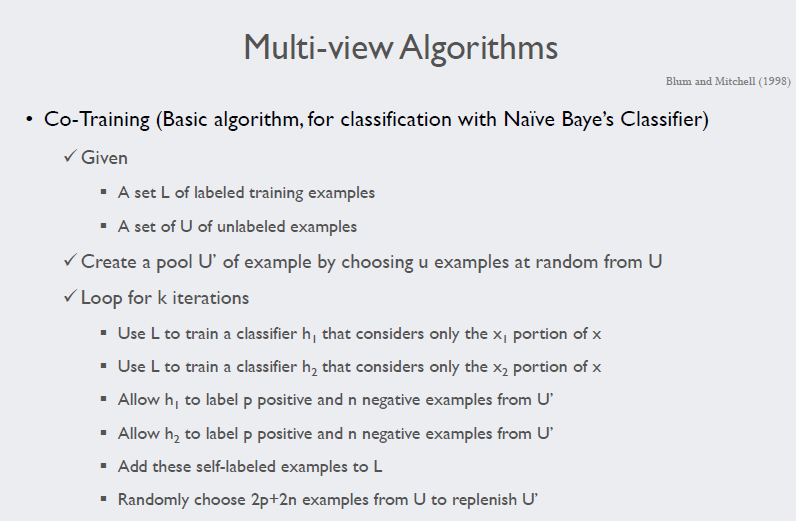

1) Blum and Mitchell(1988)이 사용한 알고리즘과 유사한 방식을 사용하였고, 다른 Classifier를 사용할 수 있도록 구성

2) Hyper Parameter는 Class1로 Labeling할 개수(p), Class2로 Labeling할 개수(n), Pool의 크기(u), 반복횟수(k)

3) 패키지와의 차이점은 Labeled data로 변경될 Unlabled data를 분류확률 기반으로 선정


# 4. Cotrianing Algorithm Code 설명

In [59]:
class CoTraining:

    def __init__(self, clf1, clf2, p, n, k, u):
        self.clf1 = clf1    # 첫 번째 Classifier
        self.clf2 = clf2    # 두 번째 Classifier
        self.p = p   # U'에서 1회 동안 Class 1로 정의할 instance 개수
        self.n = n   # U'에서 1회 동안 Class 0으로 정의할 instance 개수
        self.k = k   # U'를 업데이트 하면서 Label을 다는 과정의 반복 수
        self.u = u   # U'의 크기
        
        # hyper parameter가 0보다 작은 경우 Assert error
        assert(self.p > 0 and self.n > 0 and self.k > 0 and self.u > 0)


    def fit(self, X1, X2, y):  #Co-training을 수행 함수

        # Class의 정보가 -1인 경우 Unlabeled Data로 정의
        U = [i for i, y_i in enumerate(y) if y_i == -1]

        # U'를 랜덤하게 추출하기 위해서 Unlabeled data를 Shuffle
        random.shuffle(U)

        # parameter u의 크기로 U'를 정의
        U_ = U[-min(len(U), self.u):]

        # Unlabeled data에서 U'크기 만큼을 제외
        U = U[:-len(U_)]

        # Class의 정보가 -1이 아닌 경우 labeled Data로 정의
        L = [i for i, y_i in enumerate(y) if y_i != -1]

        it = 0 

        # k번 만큼 Unlabeled data를 Labeled data로 변화 시키는 과정
        while it != self.k and U:
            it += 1
            
            # Labeled data를 통해 두 개의 Classifier를 학습
            self.clf1.fit(X1[L], y[L])
            self.clf2.fit(X2[L], y[L])
            
            # Unlabeled data를 학습된 Classifier로 Class 예측
            y1 = self.clf1.predict(X1[U_])
            y2 = self.clf2.predict(X2[U_])
            # Unlabeled data를 학습된 Classifier로 probability 예측
            y1_proba = self.clf1.predict_proba(X1[U_])
            y2_proba = self.clf2.predict_proba(X2[U_]) 
            
            # 두 Classifier의 예측 Class가 다른 instance는 확률을 -1로 변경
            # 이 경우는 각 Classifier의 예측확률이 높아도 배제하기 위함
            for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
                if y1_i != y2_i:
                    y1_proba[i,:] = 0
                    y2_proba[i,:] = 0
            
            # 각 Classifier에서 class0, 1이 될 확률이 높은 상위 n, p개 추출
            idx_clf1_n = np.argsort(y1_proba[:,0])[-self.n:]
            idx_clf2_n = np.argsort(y2_proba[:,0])[-self.n:]
            idx_clf1_p = np.argsort(y1_proba[:,1])[-self.p:]
            idx_clf2_p = np.argsort(y2_proba[:,1])[-self.p:]
            
            # n, p의 index를 리스트화 하고 순서대로 정렬
            n = list(idx_clf1_n) + list(idx_clf2_n)
            p = list(idx_clf1_p) + list(idx_clf2_p)
            n.sort()
            p.sort()
            
            # 중복 제거
            dup_n = []
            for i in range(0, 2*self.n -1 , 1):
                if n[i] == n[i+1]:
                    dup_n.append(n[i])  
            for i in dup_n:
                n.remove(i)
            
            dup_p = []
            for i in range(0, 2*self.p -1 , 1):
                if p[i] == p[i+1]:
                    dup_p.append(p[i])  
            for i in dup_p:
                p.remove(i)
            
            # 추출된 instance의 index에 Labeling        
            y[[U_[x] for x in p]] = 1
            y[[U_[x] for x in n]] = 0
            
            # Labeling된 instance를 Label data로 추가
            L.extend([U_[x] for x in p])
            L.extend([U_[x] for x in n])
            
            # 추출된 instance(2p+2n-중복)의 index를 U'에서 제거
            remove = p + n
            remove.sort()
            remove.reverse()

            for i in remove: 
                U_.pop(i)
            
            
            # U'에서 빠진만큼 Unlabeled data에서 채워 넣기
            add_cnt = 0 
            num_to_add = len(remove)
            while add_cnt != num_to_add and U:
                add_cnt += 1
                U_.append(U.pop())

        # 최종적으로 추가완료 된 Labeled data로 각 Classifier를 학습
        self.clf1.fit(X1[L], y[L])
        self.clf2.fit(X2[L], y[L])

    # 두개의 Classifier의 Class예측 확률의 합쳐서 최종 Class 예측
    def predict(self, X1, X2):

        y1 = self.clf1.predict(X1)
        y2 = self.clf2.predict(X2)

        # 두 Classifier가 동일한 Class시 예측하면 해당 Class로 판정
        # 그렇지 않은 경우, 확률의 합의 비교하여 높은 Class로 판정
        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            if y1_i == y2_i:
                y_pred[i] = y1_i
            else:
                y1_probs = self.clf1.predict_proba([X1[i]])
                y2_probs = self.clf2.predict_proba([X2[i]])
                sum_y_probs = [prob1 + prob2 for (prob1, prob2) in zip(y1_probs, y2_probs)]
                max_sum_prob = max(sum_y_probs)
                y_pred[i] = sum_y_probs.index(max_sum_prob)
        return y_pred
    
    # 판정을 첫번째 Classifier를 통해서만 예측
    def predict_clf1(self, X1, X2):

        y_pred = self.clf1.predict(X1)

        return y_pred

# 5. 실험을 위한 Data 생성

In [60]:
if __name__ == '__main__':   
    accuracy = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    
    for iteration in range(1,11,1):
        #평가하기 위한 데이터 생성
        N_SAMPLES = 5000    # 총 instance 개수
        N_FEATURES = 10    # 총 feature개수
        N_REDUNDANT = 4    # feature간 Correlation를 가지는 feature 개수, 유의미한 경보를 가진 feature개수
        Lable_Percent = 5   # 총 instance중에 Labeled data를 백분율을 설정 (1~99)
        
        # Data 생성
        X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES,
                                   n_redundant=N_REDUNDANT, n_informative=N_REDUNDANT)

# 6. Labeled, Unlabeled Data 설정 및 Feature 나누기

In [61]:
        #Labeled, Unlabeled data를 설정
        y[:N_SAMPLES*(100-2*Lable_Percent)//100] = -1
        X_test = X[-N_SAMPLES*Lable_Percent//100:]
        y_test = y[-N_SAMPLES*Lable_Percent//100:]
        X_labeled = X[N_SAMPLES*(100-2*Lable_Percent)//100:-N_SAMPLES*Lable_Percent//100]
        y_labeled = y[N_SAMPLES*(100-2*Lable_Percent)//100:-N_SAMPLES*Lable_Percent//100]
        y = y[:-N_SAMPLES*Lable_Percent//100]
        X = X[:-N_SAMPLES*Lable_Percent//100]
        
        # Feature를 반반으로 나눔
        X1 = X[:,:N_FEATURES // 2]
        X2 = X[:, N_FEATURES // 2:]

# 7. 단일 모델의 성능 평가 (Labeled data만 사용)

In [62]:
        print ('Logistic')
        base_lr = LogisticRegression()
        base_lr.fit(X_labeled, y_labeled)
        y_pred = base_lr.predict(X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[0].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        print ('Naive Bayes Classifier')
        base_nb = GaussianNB()
        base_nb.fit(X_labeled, y_labeled)
        y_pred = base_nb.predict(X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[1].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        print ('Random Forest')
        base_rf = RandomForestClassifier(n_estimators=100)
        base_rf.fit(X_labeled, y_labeled)
        y_pred = base_rf.predict(X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[2].append('%0.3f'% accuracy_score(y_test, y_pred))

Logistic
             precision    recall  f1-score   support

          0      0.934     0.974     0.954       116
          1      0.977     0.940     0.958       134

avg / total      0.957     0.956     0.956       250

Naive Bayes Classifier
             precision    recall  f1-score   support

          0      0.947     0.931     0.939       116
          1      0.941     0.955     0.948       134

avg / total      0.944     0.944     0.944       250

Random Forest
             precision    recall  f1-score   support

          0      0.943     0.991     0.966       116
          1      0.992     0.948     0.969       134

avg / total      0.969     0.968     0.968       250



# 8. Cotrining을 수행한 후 평가

1) Cotrining을 수행한 후 최종 Class예측 시 2개의 Classifier를 모두 사용한 경우, 첫 번째 Classifier만 사용한 경우의 성능 평가 

2) 최종 Classification결과는 성능이 상대적으로 우수한 단일 Classifier를 사용하는 것이 좋은 결과

In [63]:
        # Cotrining을 이용하여 Classifier 조합별 성능 평가  
        
        # Random Forest & Random Forest Cotraining        
        print ('Random Forest-Random Forest CoTraining')
        RR_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100), p=2, n=2, k=20, u=100)
        RR_co_clf.fit(X1, X2, y)
        y_pred = RR_co_clf.predict(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[3].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RR_co_clf.predict_clf1(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[4].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        # Random Forest & Logistic Regression Cotraining
        print ('Random Forest-Logistic Regression CoTraining')
        RL_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), LogisticRegression(), p=2, n=2, k=20, u=100)
        RL_co_clf.fit(X1, X2, y)
        y_pred = RL_co_clf.predict(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[5].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RL_co_clf.predict_clf1(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[6].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        # Random Forest & Naive Bayes Classifier Cotraining
        print ('Random Forest-Naive Bayes Classifier CoTraining')
        RN_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), LogisticRegression(), p=2, n=2, k=20, u=100)
        RN_co_clf.fit(X1, X2, y)
        y_pred = RN_co_clf.predict(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[7].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RN_co_clf.predict_clf1(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES // 2:])
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[8].append('%0.3f'% accuracy_score(y_test, y_pred))

Random Forest-Random Forest CoTraining
             precision    recall  f1-score   support

          0      0.730     1.000     0.844       116
          1      1.000     0.679     0.809       134

avg / total      0.875     0.828     0.825       250

             precision    recall  f1-score   support

          0      0.705     0.802     0.750       116
          1      0.805     0.709     0.754       134

avg / total      0.758     0.752     0.752       250

Random Forest-Logistic Regression CoTraining
             precision    recall  f1-score   support

          0      0.740     0.983     0.844       116
          1      0.979     0.701     0.817       134

avg / total      0.868     0.832     0.830       250

             precision    recall  f1-score   support

          0      0.729     0.836     0.779       116
          1      0.838     0.731     0.781       134

avg / total      0.787     0.780     0.780       250

Random Forest-Naive Bayes Classifier CoTraining
        

# 9. PCA를 이용하여 새로운 Feature set을 구성하여 Cotrining을 수행한 결과

1) PCA를 통해 PC를 Feature 수만큼 생성하여 Cotrining을 수행한 성능 평가 (X1 = 기존 Feature, X2 = 모든 PCs)

2) 이런 과정을 시도해 본 이유는 informative한 feature를 나눠 가지면서 각각의 Classifier성능이 떨어지는 것으로 판단 되었기 때문 임

3) 위와 마찬가지로 최종판정은 첫 번째 Classifier만을 이용하는 것이 성능이 더 우수함

In [64]:
        # Feature를 50:50로 나누는 것이 아니라 
        # PCA를 통해 Feature 수만큼 생성하여 Cotrining을 수행한 성능 평가
        from sklearn import decomposition
        from sklearn.preprocessing import normalize
        
        pca = decomposition.PCA(n_components=N_FEATURES)
        pca.fit(normalize(X))
        X_PCA = pca.transform(normalize(X))
        pca = decomposition.PCA(n_components=N_FEATURES)
        pca.fit(normalize(X_test))
        X_PCA_test = pca.transform(normalize(X_test))

In [65]:
        # Cotrining을 이용하여 Classifier 조합별 성능 평가 (X1= All Features, X2= PCA PCs)
        
        # Random Forest & Random Forest Cotraining with PCs
        print ('Random Forest-Random Forest CoTraining with PCA')
        RR1_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100),
                                p=2, n=2, k=20, u=100)
        RR1_co_clf.fit(X, X_PCA, y)
        y_pred = RR1_co_clf.predict(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[9].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RR1_co_clf.predict_clf1(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[10].append('%0.3f'% accuracy_score(y_test, y_pred))
    
        # Random Forest & Logistic Regression Cotraining with PCs
        print ('Random Forest-Logistic Regression CoTraining with PCA')
        RL1_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), LogisticRegression(), p=2, n=2, k=20, u=100)
        RL1_co_clf.fit(X, X_PCA, y)
        y_pred = RL1_co_clf.predict(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[11].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RL1_co_clf.predict_clf1(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[12].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        # Random Forest & Naive Bayes Classifier Cotraining with PCs
        print ('Random Forest-Naive Bayes CoTraining with PCA')    
        RN1_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), GaussianNB(), p=2, n=2, k=20, u=100)
        RN1_co_clf.fit(X, X_PCA, y)
        y_pred = RN1_co_clf.predict(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[13].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RN1_co_clf.predict_clf1(X_test, X_PCA_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[14].append('%0.3f'% accuracy_score(y_test, y_pred))

Random Forest-Random Forest CoTraining with PCA
             precision    recall  f1-score   support

          0      0.928     1.000     0.963       116
          1      1.000     0.933     0.965       134

avg / total      0.967     0.964     0.964       250

             precision    recall  f1-score   support

          0      0.943     1.000     0.971       116
          1      1.000     0.948     0.973       134

avg / total      0.974     0.972     0.972       250

Random Forest-Logistic Regression CoTraining with PCA
             precision    recall  f1-score   support

          0      0.913     1.000     0.955       116
          1      1.000     0.918     0.957       134

avg / total      0.960     0.956     0.956       250

             precision    recall  f1-score   support

          0      0.943     1.000     0.971       116
          1      1.000     0.948     0.973       134

avg / total      0.974     0.972     0.972       250

Random Forest-Naive Bayes CoTraining w

# 10. Feature를 Split하지 않고 두 Classifier에서 모든 Feature를 다 이용한 성능평가

1) X1 = All Feature, X2 = All Feature

In [66]:
        # Cotrining을 이용하여 Classifier 조합별 성능 평가 (X1= All Features, X2= All Features)
        
        # Random Forest & Random Forest Cotraining without Feature Split
        print ('Random Forest-Random Forest CoTraining')
        RR2_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100),
                                p=2, n=2, k=20, u=100)
        RR2_co_clf.fit(X, X, y)
        y_pred = RR2_co_clf.predict(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[15].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RR2_co_clf.predict_clf1(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[16].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        # Random Forest & Logistic Regression Cotraining without Feature Split
        print ('Random Forest-Logistic Regression CoTraining')
        RL2_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), LogisticRegression(), p=2, n=2, k=20, u=100)
        RL2_co_clf.fit(X, X, y)
        y_pred = RL2_co_clf.predict(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[17].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RL2_co_clf.predict_clf1(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[18].append('%0.3f'% accuracy_score(y_test, y_pred))
        
        # Random Forest & Naive Bayes Classifier Cotraining without Feature Split
        print ('Random Forest-Naive Bayes Classifier CoTraining')
        RN2_co_clf = CoTraining(RandomForestClassifier(n_estimators=100), LogisticRegression(), p=2, n=2, k=20, u=100)
        RN2_co_clf.fit(X, X, y)
        y_pred = RN2_co_clf.predict(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[19].append('%0.3f'% accuracy_score(y_test, y_pred))
        y_pred = RN2_co_clf.predict_clf1(X_test, X_test)
        print (classification_report(y_test, y_pred, digits=3))
        accuracy[20].append('%0.3f'% accuracy_score(y_test, y_pred))

Random Forest-Random Forest CoTraining
             precision    recall  f1-score   support

          0      0.935     1.000     0.967       116
          1      1.000     0.940     0.969       134

avg / total      0.970     0.968     0.968       250

             precision    recall  f1-score   support

          0      0.935     1.000     0.967       116
          1      1.000     0.940     0.969       134

avg / total      0.970     0.968     0.968       250

Random Forest-Logistic Regression CoTraining
             precision    recall  f1-score   support

          0      0.928     1.000     0.963       116
          1      1.000     0.933     0.965       134

avg / total      0.967     0.964     0.964       250

             precision    recall  f1-score   support

          0      0.951     1.000     0.975       116
          1      1.000     0.955     0.977       134

avg / total      0.977     0.976     0.976       250

Random Forest-Naive Bayes Classifier CoTraining
        

# 10. 최종 결과 정리 (각 Case별로 10회 반복, Accuracy의 평균)


(1) 
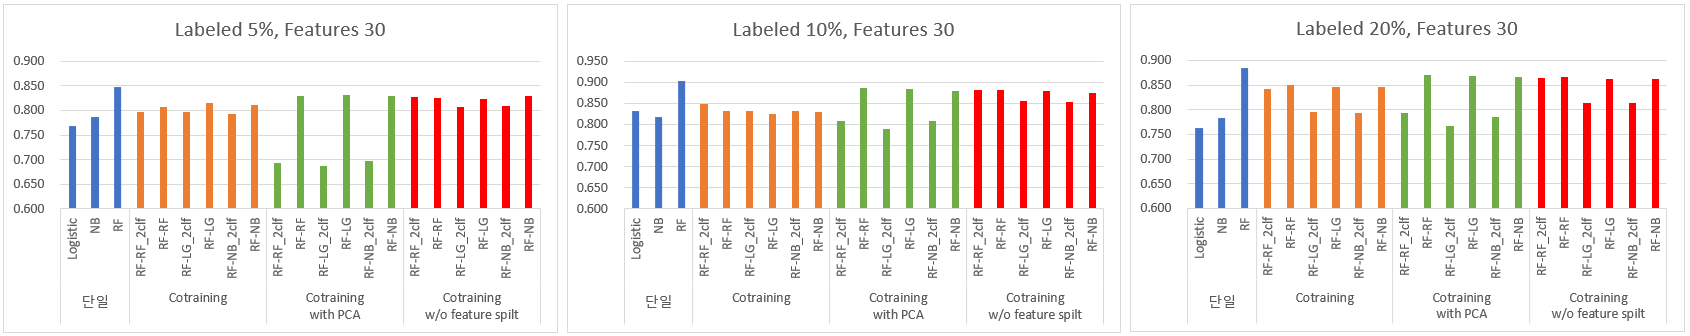

(2)
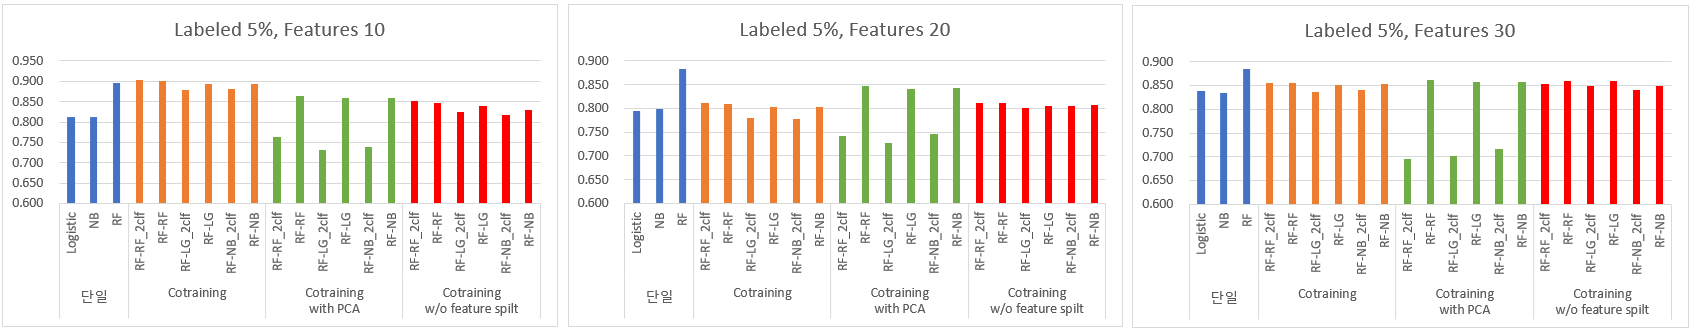


(1) Labeled Data의 비율을 변경해 가면서 평가한 결과

    (a) 가장 우수한 성능을 보이는 모델은 Random Forest 단일 모델을 Labeled data로만 학습한 모델
    
    (b) Cotraining을 구성하는 Classification을 성능 차이가 크고, Feature를 Split하면서 각 Classifier저하가 되는 것이 원인으로 추정
    
    (c) Cotraining에서는 한 Classifier는 전제 Feature, 나머지는 모든 PC를 Feature로 사용한 경우가 가장 우수한 성능
    
    (d) 하지만 Labeled data의 비율이 낮은 경우 PCA를 사용한 Classifier의 성능 저하로 인해 두 Classifier를 조합하여 최종 결과를 내는 경우에 성능 저하 발생
 
 (2) Feature의 수를 변경해가면서 평가한 결과  
 
    (a) (1)상황과 유사하게 가장 우수한 성능을 보이는 모델은 Random Forest 단일 모델을 Labeled data로만 학습한 모델
    
    (b) Feature의 개수가 가장 적은 10개의 경우에는 Cotraining의 성능이 우수하게 확인
    
 (3) 결론
    
    (a) Cotraining이 Logistic Regression, Naive Bayes Classifier 단일 모델보다는 성능이 우수함
    
    (b) Feature Split에 의한 Classifier의 성능 저하가 Cotraining의 성능 개선의 걸림돌임
    
    (c) Feature Split을 하지 않고 새로운 Feature를 extraction한 결과와 Cotraining하는 것에 대한 가능성을 확인